### Import libraries

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

In [4]:
set_gpu_limit(6)

### Split none onehot encoded data into train and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.1,random_state=2020)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=0.11,random_state=2020)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model          99186 non-null  object
 1   price          99186 non-null  int64 
 2   transmission   99186 non-null  object
 3   fuelType       99186 non-null  object
 4   binned_year    99186 non-null  int64 
 5   mil_cat        99186 non-null  int64 
 6   binned_mpg     99186 non-null  int64 
 7   engine_binned  99186 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


### We will embed columns model, transmission, and fuelType

--- 

### Garbage collect

In [21]:
gc.collect()
%reset -f out

Flushing output cache (3 entries)


### Setting up some constants

In [8]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [9]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### train, dev, and test data for NN

* model embed model input 
* transmission embed model input
* fuelType embed model input 
* numeric input data 

In [10]:
train_input,dev_input,test_input = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [22]:
base_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr)

In [23]:
base_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 4)]          0                                            
____________________________________________________________________________________________

In [13]:
# history = base_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
#                          verbose = 1, validation_data=(dev_input,y_dev),
#                          callbacks=[earlystop])

In [14]:
# base_embed_model.save("cate_embed_base_model.h5")

In [15]:
base_embed_model = tfk.models.load_model("cate_embed_base_model.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

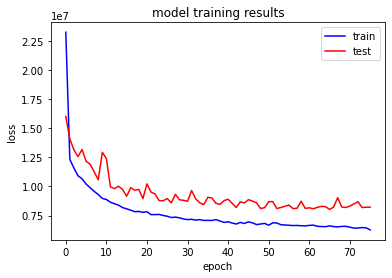

In [66]:
# plot_metrics(history,"loss")

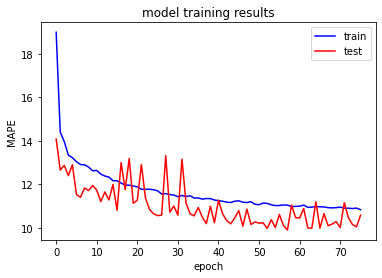

In [67]:
# plot_metrics(history,"MAPE")

### Let's check model results 

In [17]:
regression_metrics(base_embed_model,train_input,y_train,test_input,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.943838,2337.606449,695.343624
test,0.937741,2406.883565,408.698918


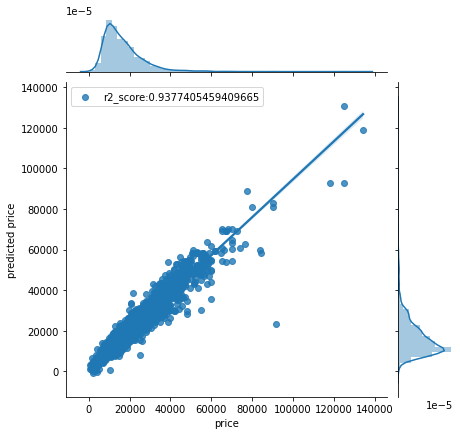

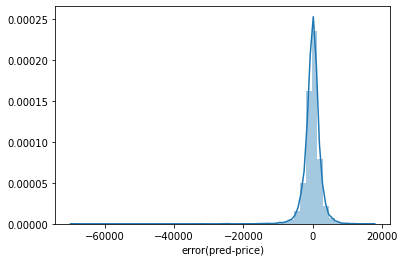

In [18]:
plot_pred_price(base_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [19]:
price_table = price_diff(base_embed_model,X_test,y_test,256, 1, test_input)

In [20]:
price_table.sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
39978,A Class,Manual,Petrol,1,5,1,0,-408.698918,408.698918
40171,A Class,Automatic,Petrol,1,4,2,0,-251.181017,251.181017
20056,Beetle,Manual,Petrol,1,4,2,0,-191.598764,191.598764
12301,Golf,Manual,Petrol,2,4,2,0,-172.129982,172.129982
2450,Yaris,Automatic,Petrol,0,4,2,0,155.427723,155.427723
85142,Z4,Automatic,Petrol,1,4,1,1,-126.068407,126.068407
98752,A6,Automatic,Diesel,2,4,2,1,-113.813571,113.813571
44326,Corsa,Manual,Petrol,1,5,2,0,105.695672,105.695672
39953,SLK,Automatic,Petrol,0,5,1,1,103.857876,103.857876
98626,TT,Manual,Petrol,1,5,1,0,-97.500380,97.500380


### Similar to other models, cars that are old with high mileage tend to be over predicted by the model 

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [24]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [25]:
bigger_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,1.5)

In [26]:
bigger_embed_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 4)]          0                                            
____________________________________________________________________________________________

In [27]:
history = bigger_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
                         verbose = 1, validation_data=(dev_input,y_dev),
                         callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 28760424.0000 - MAPE: 21.4169 - MAE: 3193.9211 - val_loss: 17023014.0000 - val_MAPE: 14.3892 - val_MAE: 2286.6714
Epoch 2/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 12540530.0000 - MAPE: 14.5504 - MAE: 2215.4780 - val_loss: 17407014.0000 - val_MAPE: 14.2792 - val_MAE: 2332.0002
Epoch 3/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 11617574.0000 - MAPE: 13.9549 - MAE: 2134.5310 - val_loss: 14042086.0000 - val_MAPE: 13.1928 - val_MAE: 2152.7290
Epoch 4/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 11239273.0000 - MAPE: 13.6920 - MAE: 2094.7297 - val_loss: 14122190.0000 - val_MAPE: 14.1583 - val_MAE: 2207.4011
Epoch 5/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 10870962.0000 - MAPE: 13.4086 - MAE: 2055.4985 - val_loss: 12977783.0000 - val_MAPE: 11.8837 - val_MAE: 1981.4014
Epoch 6/1000
2483/2483 [================

Epoch 44/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6853505.5000 - MAPE: 11.0947 - MAE: 1719.0145 - val_loss: 8859500.0000 - val_MAPE: 10.5101 - val_MAE: 1688.9923
Epoch 45/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6717188.0000 - MAPE: 11.0787 - MAE: 1713.5962 - val_loss: 8605822.0000 - val_MAPE: 10.3720 - val_MAE: 1674.4309
Epoch 46/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6816014.0000 - MAPE: 11.0772 - MAE: 1717.4172 - val_loss: 8738249.0000 - val_MAPE: 11.2216 - val_MAE: 1751.2355
Epoch 47/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6786389.5000 - MAPE: 11.0355 - MAE: 1711.2865 - val_loss: 8841802.0000 - val_MAPE: 10.9449 - val_MAE: 1735.7303
Epoch 48/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6648314.0000 - MAPE: 11.0238 - MAE: 1706.4352 - val_loss: 8823124.0000 - val_MAPE: 10.2695 - val_MAE: 1693.9362
Epoch 49/1000
2483/2483 [====================

Epoch 87/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6199446.0000 - MAPE: 10.6235 - MAE: 1640.6461 - val_loss: 7995731.5000 - val_MAPE: 10.2538 - val_MAE: 1632.4359
Epoch 88/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6138669.5000 - MAPE: 10.5529 - MAE: 1634.7981 - val_loss: 7944543.0000 - val_MAPE: 10.2605 - val_MAE: 1629.6743
Epoch 89/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6054752.0000 - MAPE: 10.5224 - MAE: 1626.1996 - val_loss: 8112951.5000 - val_MAPE: 10.0866 - val_MAE: 1629.4315
Epoch 90/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6095158.0000 - MAPE: 10.5589 - MAE: 1634.2029 - val_loss: 8155923.5000 - val_MAPE: 10.0240 - val_MAE: 1610.7968
Epoch 91/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6034015.0000 - MAPE: 10.4952 - MAE: 1625.9774 - val_loss: 7980520.5000 - val_MAPE: 9.8301 - val_MAE: 1597.8568
Epoch 92/1000
2483/2483 [=====================

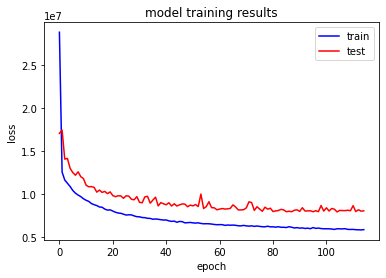

In [28]:
plot_metrics(history,"loss")

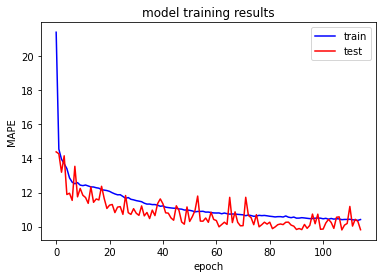

In [29]:
plot_metrics(history,"MAPE")

In [30]:
bigger_embed_model.save("bigger_embed.h5")

In [37]:
regression_metrics(bigger_embed_model,train_input,y_train,test_input,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.944789,2317.732568,559.699650
test,0.937352,2414.391473,300.850962


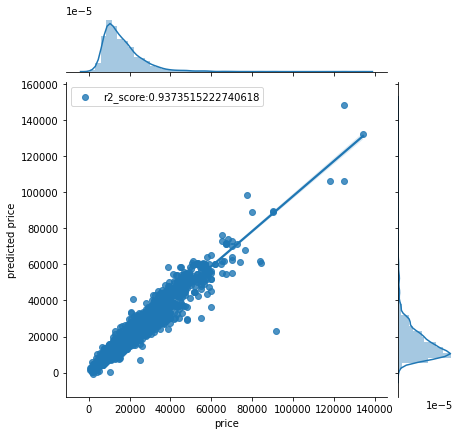

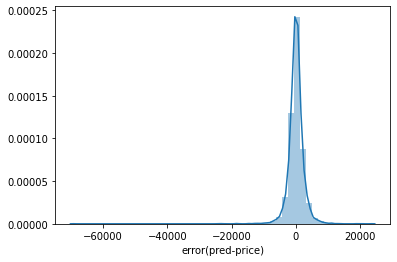

In [38]:
plot_pred_price(bigger_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [39]:
price_diff(bigger_embed_model,X_test,y_test,256, 1, test_input).sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
39978,A Class,Manual,Petrol,1,5,1,0,-300.850962,300.850962
40171,A Class,Automatic,Petrol,1,4,2,0,-230.342041,230.342041
12301,Golf,Manual,Petrol,2,4,2,0,-163.496094,163.496094
20056,Beetle,Manual,Petrol,1,4,2,0,-153.933049,153.933049
2450,Yaris,Automatic,Petrol,0,4,2,0,144.315531,144.315531
85142,Z4,Automatic,Petrol,1,4,1,1,-137.708641,137.708641
98626,TT,Manual,Petrol,1,5,1,0,-131.463641,131.463641
98752,A6,Automatic,Diesel,2,4,2,1,-120.849722,120.849722
88451,3 Series,Manual,Petrol,1,5,1,1,-98.611339,98.611339
52118,Zafira,Manual,Petrol,0,3,2,0,98.167737,98.167737


### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 